# Lisbon Machine Learning School
## Exercise 1: Classification, showcase with CMS S-top Search: Signal events vs Background events

(C) Cristóvão B. da Cruz e Silva (Laboratório de Instrumentação e Física Experimental de Partículas), cbeiraod@cern.ch


Dislcaimer: some content and examples shamelessly "stolen" from Pietro Vischia's Exercise 2

This exercise follows from the CMS analysis [https://doi.org/10.1007/JHEP09(2018)065][https://arxiv.org/abs/1805.05784] in search of pair production of the supersymmetric partner of the top quark in the situation where the difference in mass between the s-top quark and the lightest supersymmetric particle (LSP) is smaller than the W mass, in this situation the s-top quark undergoes a "four-body decay".

![StopProduction](figs/StopProd.png)

The paper above focuses on the data from 2016, while the analysis was later extended to the full Run II dataset, [https://doi.org/10.1007/JHEP06(2023)060][https://arxiv.org/abs/2301.08096].

Both papers use a BDT machine learning algorithm for classifying background and signal events. One BDT is trained for each $\Delta M$ region, where $\Delta M$ is defined as the difference in mass between the s-top and the LSP, typically a neutralino. As a result, 8 different BDTs are trained for these analysis, for each year of data taking (the years are treated independently).

SUSY models are characterised by large phase spaces which must be excluded. For these analysis a simplified model spectra model for the signal samples were used, in these models the SM is extended only by the minimal particles and interactions thought to be of relevance for what is under study, in this case the s-top and the LSP as well as their corresponding vertices in the diagram above. This still provides quite a large phase space for the analysis search, in particular the phase space covers possible masses for the LSP vs possible masses for the s-top. As a result, merging of the signal samples is desirable to reduce the analysis complexity. It can also be observed that to first order, the kinematics of the decay products depend on the $\Delta M$ quantity, so splitting by $\Delta M$ is a reasonable approach.

Given the small mass difference between the s-top and the LSP, the decay prodcuts of this channel are typically quite soft and may not fully pass strict selection criteria. For this reason the analysis requires the event to have one hard jet, this jet is interpreted to be a jet originating from Initial State Radiation (ISR) and provides a boost to the decay products of the s-top decay. For this same reason the event selection only requires one lepton and one jet from the event together with missing transverse energy, the presence of b-jets, while necessary according to the diagram is not enforced due to the low efficiency. However, the classifier of the jet with the highest b-tag is passed to the machine learning algorithm in order to provide information about the b-jet content to the ML approach. The preselection is mostly uniform for all $\Delta M$ regions, with only $\Delta M = {70,80}$ requiring a slightly tuned preselection to account for the more challenging kinematics in this region.

An iterative procedure was used in the development of these analysis and a subset of 12 input features to the BDT were observed to deliver the best performance. The variable are:
 - Jet1Pt - Transverse momentum of the leading jet
 - mt - Transverse mass
 - Met - Missing transverse energy
 - LepChg - Charge of the leading lepton
 - LepEta - Eta of the leading lepton
 - LepPt - Transverse momentum of the leading lepton
 - HT - sum of the transverse momentum of all particles in the event
 - NbLoose - number of jets passing loose b-jet criteria
 - Njet - number of jets
 - JetHBpt - Transverse momentum of the jet with the highest b-tag score
 - DrJetHBLep - $\Delta R$ between the jet with the highest b-tag score and the leading lepton
 - JetHBCSV - B-tag score of the jet with the highest b-tag score

Included in the nTuples are several other variables considered to be possibly useful for the analysis, an invested individual could explore the use of these other features in addition or in alternative to the ones aboves.

In this exercise we will reimplement this analysis using a Neural Network algorithm and compare the performance to that of the BDT approach used in the papers. The exact same BDT classifiers used in the 2016 analysis were applied to these MC samples and the output is stored in a separate nTuple and loaded as an additional column, providing us easy access to perform a preliminary comparison.

## Setup the environment

- If you are running locally, you don't need to run anything, but make sure to point the base_data_dir variable to the directory where you have the data

- If you are running on Google Colab, uncomment and run the next cell (remove only the "#", keep the "!"). You can also run it from a local installation, but it will do nothing if you have already installed all dependencies (and it will take some time to tell you it is not gonna do anything).



In [1]:
from google.colab import drive
drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/lisbon-ml-school.git
#%cd lisbon-ml-school
#!pwd
#!ls

Mounted at /content/drive


## Fetch the data

If you have not yet retrieved the data and placed it into an appropriate folder you can access either from google drive or on your local computer, follow the equivalent steps below.

The steps below should work for colab without any modification, you will need to modify them to run locally on your machine.

In [2]:
import os
# To run locally:
if not os.path.isdir("/content/drive/MyDrive/") and not os.path.isdir("data/Lisbon_ML_School_Stop"):
    !cd data/; wget https://cernbox.cern.ch/remote.php/dav/public-files/fBw0wnuLt1CWFGa/Lisbon_ML_School_Stop.tar.gz; tar xzvf Lisbon_ML_School_Stop.tar.gz; cd -;
# To run in colab:
if os.path.isdir("/content/drive/MyDrive/") and not os.path.isfile("/content/drive/MyDrive/Lisbon_ML_School_Stop/Data/ZZ.root"):
    !cd /content/drive/MyDrive; wget https://cernbox.cern.ch/remote.php/dav/public-files/fBw0wnuLt1CWFGa/Lisbon_ML_School_Stop.tar.gz; tar xzvf Lisbon_ML_School_Stop.tar.gz; cd -;

## Load the needed libraries

In [3]:
if os.path.isdir("/content/drive/MyDrive/"): # Only on colab, locally you should have already installed these packages via conda
    !pip install torchinfo
    !pip install uproot
    !pip install pyhf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 11.2 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchinfo
from tqdm import tqdm

import sklearn
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc, accuracy_score

import uproot

import pandas

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import plotly.express as px

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_dtype(torch.float32)

print('Using torch version', torch.__version__)

Using torch version 2.5.1+cu124


## Load the data

We use the [uproot](https://uproot.readthedocs.io/en/latest/basic.html) library to conveniently read in a [ROOT TNuple](https://root.cern.ch/doc/master/classTNtuple.html) which can automatically convert it to a [pandas dataframe](https://pandas.pydata.org/).

In [5]:
def load_dataframe(base_dir, dataset, bdt = True, treename = 'data', previous_dataframes = None, do_split = True, train_factor=0.5, seed = None, category=None, subcategory=None):
  if seed is not None:
    np.random.seed(seed = seed)
  if previous_dataframes is not None and dataset in previous_dataframes:
    df = previous_dataframes[dataset]
  elif dataset[-5:] == '.root':
    # Load base data
    df = uproot.open(os.path.join(base_dir, 'Data', dataset))[treename].arrays(library='pd')
    #df = uproot.open(os.path.join(base_dir, 'DataC', dataset))[treename].arrays(library='pd') # DataC may be better optimized for ML, maybe the students can check

    # Load friend trees
    if bdt:
      df_bdt = uproot.open(os.path.join(base_dir, 'BDT', dataset))[treename].arrays(library='pd')
      df = pandas.concat([df,df_bdt],axis=1)
      del df_bdt

    # Apply final selections
    # Preselection is already applied:
    #     "(tightLepton) && (DPhiJet1Jet2 < 2.8 || Jet2Pt < 67) && (HT > 181) && (Met > 254) && (Jet1Pt > 100)",
    # For High DM (only 70 and 80), apply final selection of:
    #     "(DPhiJet1Jet2 < 2.5 || Jet2Pt < 60) && (HT > 200) && (Met > 280) && (Jet1Pt > 110)",
    # For Low DM, apply final selection of:
    #     "(DPhiJet1Jet2 < 2.5 || Jet2Pt < 60) && (HT > 200) && (Met > 280) && (Jet1Pt > 110) && (LepPt < 30)",
    #sel = (df['DPhiJet1Jet2'] < 2.5) | (df['Jet2Pt'] < 60) & (df['HT'] > 200) & (df['Met'] > 280) & (df['Jet1Pt'] > 110)
    sel = (df['DPhiJet1Jet2'] < 2.5) | (df['Jet2Pt'] < 60) & (df['HT'] > 200) & (df['Met'] > 280) & (df['Jet1Pt'] > 110) & (df['LepPt'] < 30)
    df = df.loc[sel]

    # Split train/test
    if do_split:
      2+2
      #df['isTrain'] = np.random.choice([True, False], size=len(df), p=[train_factor, 1-train_factor])

    # Apply ne columns
    if category is not None:
      df['category'] = category
    if subcategory is not None:
      df['subcategory'] = subcategory
  else:
    if len(dataset) > 2 and dataset[:2] == 'DM' and int(dataset[2:]) in [10, 20, 30, 40, 50, 60, 70, 80]:
      dm = int(dataset[2:])
      ds_list = []
      for stopM in range(250, 801, 25):
        neutM = stopM - dm
        ds_list.append((f'T2DegStop_{stopM}_{neutM}.root', f'Signal_{stopM}_{neutM}'))
    elif dataset == 'DYJets':
      ds_list = [
          'DYJetsToLL_M5to50_HT100to200.root',
          'DYJetsToLL_M5to50_HT200to400.root',
          'DYJetsToLL_M5to50_HT400to600.root',
          'DYJetsToLL_M5to50_HT600toInf.root',
          'DYJetsToLL_M50_HT100to200.root',
          'DYJetsToLL_M50_HT200to400.root',
          'DYJetsToLL_M50_HT400to600.root',
          'DYJetsToLL_M50_HT600to800.root',
          'DYJetsToLL_M50_HT800to1200.root',
          'DYJetsToLL_M50_HT1200to2500.root',
          'DYJetsToLL_M50_HT2500toInf.root',
      ]
    elif dataset == 'QCD':
      ds_list = [
          'QCD_HT50to100.root',
          'QCD_HT100to200.root',
          'QCD_HT200to300.root',
          'QCD_HT300to500.root',
          'QCD_HT500to700.root',
          'QCD_HT700to1000.root',
          'QCD_HT1000to1500.root',
          'QCD_HT1500to2000.root',
          'QCD_HT2000toInf.root',
      ]
    elif dataset == 'SingleT':
      ds_list = [
          'T_tch_powheg.root',
          'T_tWch_ext.root',
          'TBar_tch_powheg.root',
          'TBar_tWch_ext.root',
      ]
    elif dataset == 'TT_Pow':
      ds_list = [
          #'TT_pow_backup.root',
          'TT_pow.root',
      ]
    elif dataset == 'TTLep':
      ds_list = [
          'TTJets_DiLepton.root',
          'TTJets_SingleLeptonFromT.root',
          'TTJets_SingleLeptonFromTbar.root',
      ]
    elif dataset == 'TTX':
      ds_list = [
          'TTGJets.root',
          'TTWToLNu.root',
          'TTWToQQ.root',
          'TTZToLLNuNu_m1to10.root',
          'TTZToLLNuNu.root',
          'TTZToQQ.root',
      ]
    elif dataset == 'WJets':
      ds_list = [
          'Wjets_70to100.root',
          'Wjets_100to200.root',
          'Wjets_200to400.root',
          'Wjets_400to600.root',
          'Wjets_600to800.root',
          'Wjets_800to1200.root',
          'Wjets_1200to2500.root',
          'Wjets_2500toInf.root',
      ]
    elif dataset == 'Diboson':
      ds_list = [
          'WW.root',
          'WZ.root',
          'ZZ.root',
      ]
    elif dataset == 'ZInv':
      ds_list = [
          'ZJetsToNuNu_HT100to200.root',
          'ZJetsToNuNu_HT200to400.root',
          'ZJetsToNuNu_HT400to600.root',
          'ZJetsToNuNu_HT600to800.root',
          'ZJetsToNuNu_HT800to1200.root',
          'ZJetsToNuNu_HT1200to2500.root',
          'ZJetsToNuNu_HT2500toInf.root',
      ]
      #'TTW_LO.root',
      #'TTZ_LO.root',
    elif dataset == "Background_TTPow":
      ds_list = [
          'TT_Pow',
          'WJets',
      ]
    elif dataset == "Background_TTPow_ZInv":
      ds_list = [
          'TT_Pow',
          'WJets',
          'ZInv',
      ]
    elif dataset == "Background_TTLep":
      ds_list = [
          'TTLep',
          'WJets',
      ]
    elif dataset == "Background_TTLep_ZInv":
      ds_list = [
          'TTLep',
          'WJets',
          'ZInv',
      ]
    else:
      raise RuntimeError(f"Unable to find dataset {dataset}")
    df = None
    for ds in ds_list:
      if isinstance(ds, tuple):
        subcat = ds[1]
        ds = ds[0]
      else:
        subcat = subcategory
      new_df = load_dataframe(base_dir, ds, bdt = bdt, treename = treename, previous_dataframes = previous_dataframes, category=category, subcategory=subcat)
      if previous_dataframes is not None:
        if ds not in previous_dataframes:
          previous_dataframes[ds] = new_df
      if df is None:
        df = new_df
      else:
        df = pandas.concat([df, new_df], ignore_index=True)
        if previous_dataframes is None:
          del new_df
  #df.set_index('Event', inplace=True)
  return df

def load_all_dataframes(base_dir, bdt = True, treename = 'data', seed = None):
  if seed is not None:
    np.random.seed(seed = seed)

  dataframes = {}

  # Signal samples per \DeltaM
  #dataframes['DM10'] = load_dataframe(base_dir, "DM10", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  #dataframes['DM20'] = load_dataframe(base_dir, "DM20", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  dataframes['DM30'] = load_dataframe(base_dir, "DM30", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Signal")
  #dataframes['DM40'] = load_dataframe(base_dir, "DM40", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  #dataframes['DM50'] = load_dataframe(base_dir, "DM50", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  #dataframes['DM60'] = load_dataframe(base_dir, "DM60", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  #dataframes['DM70'] = load_dataframe(base_dir, "DM70", bdt = bdt, treename = treename, previous_dataframes = dataframes)
  #dataframes['DM80'] = load_dataframe(base_dir, "DM80", bdt = bdt, treename = treename, previous_dataframes = dataframes)

  # Example points from different DM
  # DM 10
  dataframes['T2DegStop_250_240.root'] = load_dataframe(base_dir, "T2DegStop_250_240.root", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Signal", subcategory="Signal_250_240")
  # DM 30
  dataframes['T2DegStop_250_220.root'] = load_dataframe(base_dir, "T2DegStop_250_220.root", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Signal", subcategory="Signal_250_220")
  # DM 50
  dataframes['T2DegStop_250_200.root'] = load_dataframe(base_dir, "T2DegStop_250_200.root", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Signal", subcategory="Signal_250_200")
  # DM 80
  dataframes['T2DegStop_250_170.root'] = load_dataframe(base_dir, "T2DegStop_250_170.root", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Signal", subcategory="Signal_250_170")

  # Individual MC samples
  dataframes['DYJets'] = load_dataframe(base_dir, "DYJets", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="DYJets")
  dataframes['QCD'] = load_dataframe(base_dir, "QCD", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="QCD")
  dataframes['SingleT'] = load_dataframe(base_dir, "SingleT", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="SingleTop")
  dataframes['TT_Pow'] = load_dataframe(base_dir, "TT_Pow", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="TT")
  dataframes['TTLep'] = load_dataframe(base_dir, "TTLep", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="TT")
  dataframes['TTX'] = load_dataframe(base_dir, "TTX", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="TTX")
  dataframes['WJets'] = load_dataframe(base_dir, "WJets", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="WJets")
  dataframes['Diboson'] = load_dataframe(base_dir, "Diboson", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="VV")
  dataframes['ZInv'] = load_dataframe(base_dir, "ZInv", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="ZInv")

  # Choose your favorite background model, but only 1
  #dataframes['Background'] = load_dataframe(base_dir, "Background_TTPow", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="Other")
  #dataframes['Background'] = load_dataframe(base_dir, "Background_TTPow_ZInv", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="Other")
  dataframes['Background'] = load_dataframe(base_dir, "Background_TTLep", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="Other")
  #dataframes['Background'] = load_dataframe(base_dir, "Background_TTLep_ZInv", bdt = bdt, treename = treename, previous_dataframes = dataframes, category="Background", subcategory="Other")

  return dataframes

In [6]:
base_data_dir=None

# To run locally:
if not os.path.isdir("/content/drive/MyDrive/") and os.path.isdir("data/Lisbon_ML_School_Stop"):
    base_data_dir = 'data/Lisbon_ML_School_Stop'
if os.path.isdir("/content/drive/MyDrive/") and os.path.isfile("/content/drive/MyDrive/Lisbon_ML_School_Stop/Data/ZZ.root"):
    base_data_dir = '/content/drive/MyDrive/Lisbon_ML_School_Stop'


dataframes = load_all_dataframes(base_data_dir, seed = 42)

In [ ]:
list(dataframes.keys())

## Inspect the data

Before applying any "fancy" methods to the data, it is better to understand what the data is and looks like. **Spend some time exploring the data**.


We have loaded several dataframes with simulated data for different processes, of particular interest to us are the signal dataframes and background dataframe. All dataframes have the same structure, let's start by looking at the structure of one of the dataframes:
   

In [10]:
print(dataframes['T2DegStop_250_220.root'].columns)
print(len(dataframes['T2DegStop_250_220.root']))


Index(['Run', 'Event', 'LumiSec', 'Nevt', 'XS', 'nVert', 'weight', 'genWeight',
       'sumGenWeight', 'LepID', 'LepChg', 'LepPt', 'LepEta', 'LepDxy', 'LepDz',
       'LepIso', 'Lep2ID', 'Lep2Chg', 'Lep2Pt', 'Lep2Eta', 'Lep2Dxy', 'Lep2Dz',
       'Lep2Iso', 'nGoodMu', 'nGoodEl', 'Met', 'mt', 'Q80', 'CosDeltaPhi',
       'Njet', 'Njet30', 'Njet50', 'Njet80', 'Njet100', 'Jet1Pt', 'Jet1Eta',
       'Jet1CSV', 'Jet2Pt', 'Jet2Eta', 'Jet2CSV', 'Jet3Pt', 'Jet3Eta',
       'Jet3CSV', 'DPhiJet1Jet2', 'HT', 'NbLoose', 'NbTight', 'NbLooseTo50',
       'NbLoose50', 'NbTightTo50', 'NbTight50', 'JetHBpt', 'JetHBeta',
       'JetHBCSV', 'JetB2pt', 'JetB2eta', 'JetB2CSV', 'DrJet1Lep', 'DrJet2Lep',
       'DrJetHBLep', 'DrJet1Jet2', 'JetLepMass', 'J3Mass', 'BDT10', 'BDT20',
       'BDT30', 'BDT40', 'BDT50', 'BDT60', 'BDT70', 'BDT80', 'category',
       'subcategory'],
      dtype='object')
24321


Most of the variables are reconstructed properties of the event, typically properties of the reconstructed particles. There are a number of special variables:

- `BDT*`: these 8 variables are the result of applying the BDT methods from the publication to the event data, remember there are 8 different BDTs, one for each $\Delta M$, when analysing signal samples, we should only look at the corresponding BDT variable and when analysing background samples we should look at the BDT variable corresponding to the $\Delta M$ region we are analysing. For this exercise, we are considering only one region, $\Delta M = 30\,\text{GeV}$.
- `Run`, `Event`, `LumiSec`: these 3 variables uniquely identify each event, and are not really important for this exercise
- `Nevt`, `genWeight`, `sumGenWeight`: are variables necessary for correctly weighing simulated events
- `XS`: is the cross section to consider for the process when calculating yields
- `weight`: is the weight to apply to the event for calculating yields

### Plotting histograms of some observables using plotly
Plotly is built on top of matplotlib and provides a bunch of useful and visually pleasing plotting options, it also offers interactive graphs which are great when exploring your data. See examples on [plotly](https://plotly.com/python/) website

Plotly is excellent for providing interactive figures but this comes at the cost of the raw information having to be stored together with the figure. Plotly figures can use a lot of space and be very slow if there are many points. For this reason we limit the number of events in each plot below, by sampling from the dataframes, which should still give us a statistically relevant representation.

Below we take a look at the $p_T$ distribution of the leading lepton for one of the signal samples

In [14]:
df = dataframes['T2DegStop_250_220.root'].sample(n=6000)
fig = px.histogram(
    df,
    x='LepPt',
    y='weight',
    histfunc='sum',
    title='Leading Lepton Transverse Momentum',
    labels={'LepPt': 'Lepton 1 $p_T$ [GeV]'},
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=100.0,
        size=1
    ))
fig.update_layout(yaxis_title="Weight")
fig.show()
del df

We can compare the signal sample against one or more background samples, here we consider the leading Jet $p_T$

In [17]:
df = pandas.concat([dataframes['T2DegStop_250_220.root'].sample(n=6000), dataframes['WJets'].sample(n=12000)])
fig = px.histogram(
    df,
    x='Jet1Pt',
    y='weight',
    histfunc='sum',
    title='Leading Jet Transverse Momentum - WJets vs Signal',
    labels={'Jet1Pt': 'Jet 1 $p_T$ [GeV]'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
    #marginal="rug",
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=800.0,
        size=4
    ))
fig.update_layout(yaxis_title="Weight")

fig.show()

del df

Each process has a different expected amount of events, which makes it hard to compare the shape, so we artificially modify the weights to get histograms with similar area:

In [18]:
df_sig = dataframes['T2DegStop_250_220.root'].sample(n=6000)
df_back = dataframes['WJets'].sample(n=12000)

df_sig["weight"] = df_sig["weight"]*(df_back["weight"].sum())/(df_sig["weight"].sum())
df = pandas.concat([df_sig, df_back])
fig = px.histogram(
    df,
    x='Jet1Pt',
    y='weight',
    histfunc='sum',
    title='Leading Jet Transverse Momentum - WJets vs Signal',
    labels={'Jet1Pt': 'Jet 1 $p_T$ [GeV]'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
    #marginal="rug",
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=800.0,
        size=4
    ))
fig.update_layout(yaxis_title="Weight")
fig.show()

In [19]:
# Some clean up
del df
del df_sig
del df_back

We should compare the different signal points against each other to verify our expectation that the events kinematics depend to first order on the $\Delta M$ quantity. Let check some properties within a $\Delta M$ region:

In [20]:
# Build dataframe for some signals points with same DM
df_1 = dataframes['T2DegStop_250_220.root'].copy(deep=True)
df_1['weight'] = df_1['weight']/(df_1['weight'].sum())
df_2 = dataframes['T2DegStop_300_270.root'].copy(deep=True)
df_2['weight'] = df_2['weight']/(df_2['weight'].sum())
df_3 = dataframes['T2DegStop_500_470.root'].copy(deep=True)
df_3['weight'] = df_3['weight']/(df_3['weight'].sum())
df_4 = dataframes['T2DegStop_650_620.root'].copy(deep=True)
df_4['weight'] = df_4['weight']/(df_4['weight'].sum())
df_5 = dataframes['T2DegStop_800_770.root'].copy(deep=True)
df_5['weight'] = df_5['weight']/(df_5['weight'].sum())
df = pandas.concat([
    df_1,
    df_2,
    df_3,
    df_4,
    df_5,
                    ])

In [23]:
# Plot lep PT
fig = px.histogram(
    df.sample(n=12000),
    x='LepPt',
    y='weight',
    histfunc='sum',
    title='Leading Lepton Transverse Momentum - Different DM=30 signals',
    labels={'LepPt': 'Lepton 1 $p_T$ [GeV]'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=100.0,
        size=1
    ))
fig.update_layout(yaxis_title="Weight")

fig.show()

In [24]:
# Plot mt
fig = px.histogram(
    df.sample(n=12000),
    x='mt',
    y='weight',
    histfunc='sum',
    title='Event transverse mass - Different DM=30 signals',
    labels={'mt': '$m_T$'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=500.0,
        size=10
    ))
fig.update_layout(yaxis_title="Weight")

fig.show()

In [25]:
# Clean up
del df
del df_1
del df_2
del df_3
del df_4
del df_5

Now, let's compare signal samples from different $\Delta M$ regions:

In [26]:
# Build dataframe for some signals points with different DM
df_1 = dataframes['T2DegStop_250_240.root'].copy(deep=True)
df_1['weight'] = df_1['weight']/(df_1['weight'].sum())
df_2 = dataframes['T2DegStop_250_220.root'].copy(deep=True)
df_2['weight'] = df_2['weight']/(df_2['weight'].sum())
df_3 = dataframes['T2DegStop_250_200.root'].copy(deep=True)
df_3['weight'] = df_3['weight']/(df_3['weight'].sum())
df_4 = dataframes['T2DegStop_250_170.root'].copy(deep=True)
df_4['weight'] = df_4['weight']/(df_4['weight'].sum())
df = pandas.concat([
    df_1,
    df_2,
    df_3,
    df_4,
                    ])

In [27]:
# Plot lep PT
fig = px.histogram(
    df.sample(n=12000),
    x='LepPt',
    y='weight',
    histfunc='sum',
    title='Leading Jet Transverse Momentum - Signals with Different DM',
    labels={'Jet1Pt': 'Jet 1 $p_T$ [GeV]'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=100.0,
        size=1
    ))
fig.update_layout(yaxis_title="Weight")

fig.show()

In [28]:
# Plot DR Jet1 Lep
fig = px.histogram(
    df.sample(n=12000),
    x='mt',
    y='weight',
    histfunc='sum',
    title='Event transverse mass - Signals with Different DM',
    labels={'mt': '$m_T$'},
    color="subcategory",
    barmode="overlay", # Without this option, plotly will stack the histograms by default
)
fig.update_traces(xbins=dict( # bins used for histogram
        start=0.0,
        end=500.0,
        size=10
    ))
fig.update_layout(yaxis_title="Weight")

fig.show()

In [29]:
# clean up
del df
del df_1
del df_2
del df_3
del df_4

### Multiple scatter plots

We can also do scatter plots of variables against other variables, keep in mind that scatter plots implement one point per entry in the dataframe and so do not respect the event weighting of the MC samples, but they are stil very useful for understanding correlations in the data

In [30]:
df = pandas.concat([dataframes['T2DegStop_250_220.root'], dataframes['ZInv'], dataframes['Diboson']])
fig = px.scatter_matrix(
    df.sample(n=30000),
    dimensions=["LepPt", "LepEta", "Met", "mt", "Q80", "HT"],
    color="subcategory"
                        )
fig.update_traces(diagonal_visible=False, showupperhalf=False,)
fig.show()
del df

In the interactive plot above we can enable and disable the different colors to inspect them individually or together, we can also lasso select some of the scatter points in one of the plots and see how those specific points behave in the other plots. This is an extremely useful tool for exploring and understanding the data.


### Plots of Subleading variables

Now let's look at one of the variables which does not belong to one of the leading objects or one of the event level quantities:

In [32]:
df = dataframes['WJets'].sample(n=15000)
fig = px.histogram(
    df,
    x='Jet2Pt',
    y='weight',
    histfunc='sum',
    title='Subleading Jet Transverse Momentum',
    labels={'Jet2Pt': 'Jet 2 $p_T$ [GeV]'},
)
# Purposefully removing setting the binning
#fig.update_traces(xbins=dict( # bins used for histogram
#        start=0.0,
#        end=100.0,
#        size=1
#    ))
fig.update_layout(yaxis_title="Weight")
fig.show()
del df

What is up with the large peak at -10000?


.

.

.

.

.

.

.

.



The preselection of this analysis selects events with at least one lepton and at least one jet. Events with more objects of each will pass these criteria, but not all events will have multiple leptons and/or jets.

As a result, a default "unphysical" value of -9999 is attributed to events where not all objects are present. this should serve as a "pseudo-categorical" variable for any machine learning approach. However, the magnitude of the unphysical default value may have an affect on the ML performance, if you want to evaluate what the effect of using a different default value may be, use the `DataC` data directory, which uses a significantly smaller magnitude value than -10000.

We will use the approach of considering all the data, but there are other equally valid approaches, for instance we could consider only events with 1 lepton and 1 jet and eventually train additional algorithms for events with 2 leptons and 1 jet, 2 leptons and 2 jets and so on.

### Correlation matrix

Evaluating the correlation matrix of the features allows to evaluate which ones are highly correlated and identify which ones could possibly not be included in the set of input features of the ML algorithm.

What is particularly relevant in this application is the correlations in the different classes. If a pair of features are highly correlated in one class and not correlated in another, this information can be exploited by the ML algorithm to better separate the classes.

We will be using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which only captures linear correlations, so the figure below is not a complete picture

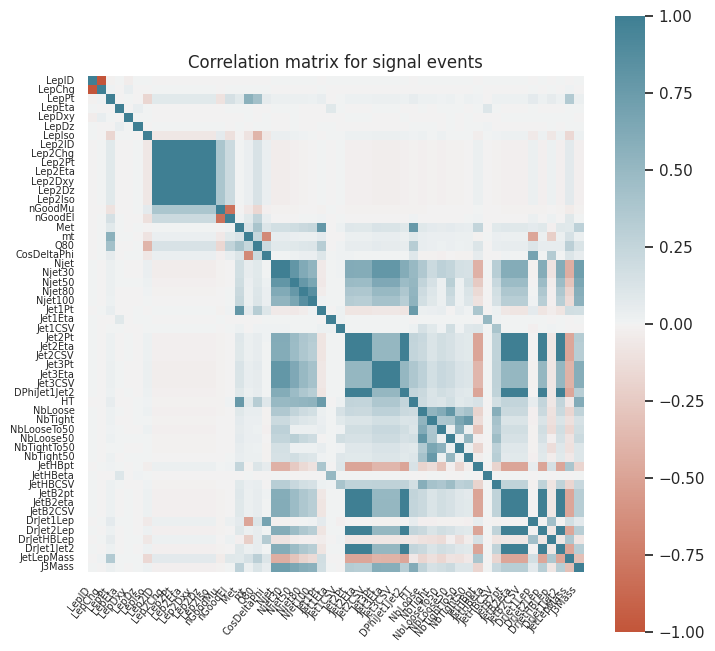

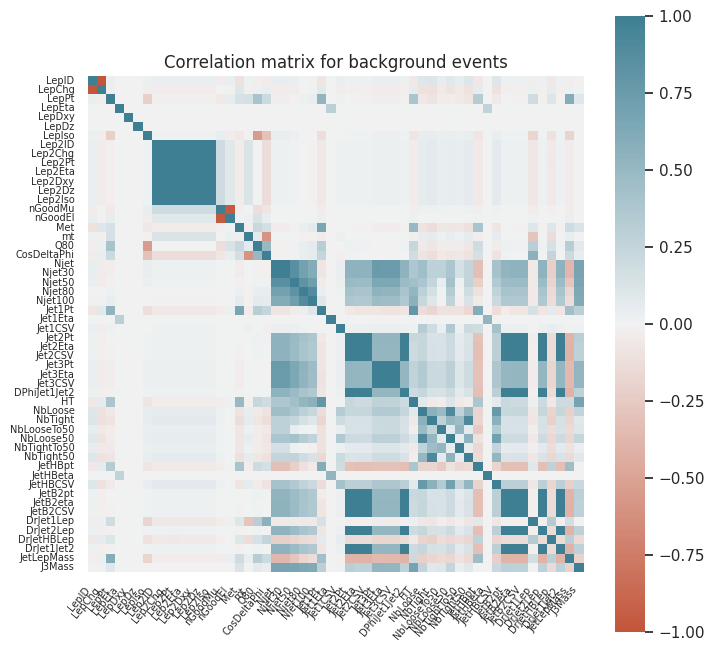

In [42]:
import seaborn as sns
sns.set()

def corrmatrix(corr, label):
    plt.figure()
    ax = sns.heatmap(
        corr,
        vmin=-1., vmax=1., center=0.,
        cmap=sns.diverging_palette(20., 220., n=200, as_cmap=True),
        square=True, xticklabels=True, yticklabels=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=50,
        horizontalalignment='right',
        fontsize = 7
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        horizontalalignment='right',
        fontsize = 7
    )

    ax.set_title('Correlation matrix for %s events' % label)

    plt.show()
    plt.close()


drop_cols = [
    'Run',
    'Event',
    'LumiSec',
    'Nevt',
    'XS',
    'nVert',
    'weight',
    'genWeight',
    'sumGenWeight',
    'BDT10',
    'BDT20',
    'BDT30',
    'BDT40',
    'BDT50',
    'BDT60',
    'BDT70',
    'BDT80',
    #'isTrain',
    'category',
    'subcategory',
]

corrmatrix(dataframes["DM30"].drop(drop_cols, axis=1).corr(), 'signal')
corrmatrix(dataframes["Background"].drop(drop_cols, axis=1).corr(), 'background')

## Prepare data for ML

For training the ML algorithm we will not use all the MC background processes, but only a selection of the main processes. This includes $t\bar{t}$ and WJets processes. There are two separate simulated MC samples for $t\bar{t}$ and the ZInv MC sample can also optionally be included. This gives a few different options for choosing on what to train the model, if you want to try a different option, scroll up and change the relevant line in the load dataframe function.

We will also have to create a label for signal or background events, which will serve as the target for the ML algorithm and join the datafraes together. We will also drop a number of the features, keeping only those which we want the ML algorithm to train on. In order to maintain parity with the paper, we will use by default the same set as there, but please consider trying different features to see if you are able to improve upon the paper results.

In [7]:
# Create a new column 'label' and set its value to 1 or 0 for all rows (=events)
sig = dataframes['DM30'].copy(deep=True)
bkg = dataframes['Background'].copy(deep=True)
sig['label'] = 1
bkg['label'] = 0

# Merge the signal and background into one dataframe
print(f"Signal shape {sig.shape}")
print(f"Bkg shape {bkg.shape}")

data = pandas.concat([sig,bkg])

print(f"Data shape {data.shape}")
print(data.columns)

# Drop unneeded features, If you are using a different DM region, keep the BDT of your DM here instead of BDT30
data = data[["Jet1Pt","mt","Met","LepChg","LepEta","LepPt","HT","NbLoose","Njet","JetHBpt","DrJetHBLep","JetHBCSV","BDT30","weight","label"]]

print(f" Data shape {data.shape}")
print(data.columns)
print(f"In this dataframe we finally have {data[data['label']==1].shape[0]} signal and {data[data['label']==0].shape[0]} background events")

Signal shape (386631, 74)
Bkg shape (1894766, 74)
Data shape (2281397, 74)
Index(['Run', 'Event', 'LumiSec', 'Nevt', 'XS', 'nVert', 'weight', 'genWeight',
       'sumGenWeight', 'LepID', 'LepChg', 'LepPt', 'LepEta', 'LepDxy', 'LepDz',
       'LepIso', 'Lep2ID', 'Lep2Chg', 'Lep2Pt', 'Lep2Eta', 'Lep2Dxy', 'Lep2Dz',
       'Lep2Iso', 'nGoodMu', 'nGoodEl', 'Met', 'mt', 'Q80', 'CosDeltaPhi',
       'Njet', 'Njet30', 'Njet50', 'Njet80', 'Njet100', 'Jet1Pt', 'Jet1Eta',
       'Jet1CSV', 'Jet2Pt', 'Jet2Eta', 'Jet2CSV', 'Jet3Pt', 'Jet3Eta',
       'Jet3CSV', 'DPhiJet1Jet2', 'HT', 'NbLoose', 'NbTight', 'NbLooseTo50',
       'NbLoose50', 'NbTightTo50', 'NbTight50', 'JetHBpt', 'JetHBeta',
       'JetHBCSV', 'JetB2pt', 'JetB2eta', 'JetB2CSV', 'DrJet1Lep', 'DrJet2Lep',
       'DrJetHBLep', 'DrJet1Jet2', 'JetLepMass', 'J3Mass', 'BDT10', 'BDT20',
       'BDT30', 'BDT40', 'BDT50', 'BDT60', 'BDT70', 'BDT80', 'category',
       'subcategory', 'label'],
      dtype='object')
 Data shape (2281397, 15)
Inde

This data set is still ordered, ie. each signal point comes after each other, followed by the background events, first $t\bar{t}$ and then WJets. ML training requires a shuffled data set instead.

It is good practice to shuffle the data as soon as possible even though shuffling can be done at the time of splitting into the training and testing datasets.

We will also separate features and labels from each other, and check for corrupted values.

In [8]:
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

Jet1Pt          mt         Met  LepChg    LepEta       LepPt  \
0  170.812027   59.025307  283.524658    -1.0 -1.103747   43.288559   
1  623.127075   69.007614  750.066101     1.0 -2.111530    7.592854   
2  597.860718    9.506464  543.263428     1.0 -0.647769   37.701435   
3  402.626251   25.222334  347.739197    -1.0  1.229182   15.247771   
4  427.886353   68.312485  467.457062     1.0  1.097778   66.162033   
5  211.338455  323.552277  262.909760     1.0 -1.150423  139.599915   
6  563.205566   69.953430  561.166565     1.0 -0.822846  134.509064   
7  535.521057   17.750578  529.755615     1.0  1.459796   10.272532   
8  219.246475   75.050316  375.473785     1.0  0.618618    8.253841   
9  362.961334   92.054657  360.723785     1.0 -1.433356   47.262520   

            HT  NbLoose  Njet     JetHBpt  DrJetHBLep  JetHBCSV     BDT30  \
0   208.125061      1.0   2.0   37.313042    2.305139  0.805508 -0.253218   
1   838.798828      0.0   4.0   43.833740    3.514325  0.270858  0.209277   
2   632.091736      0.0   2.0  597.860718    3.140911  0.302820 -0.114508   
3   402.626251      0.0   1.0  402.626251    3.594095  0.161643  0.066908   
4  1267.075073      1.0   5.0   40.511299    1.287093  0.689782 -0.324068   
5   211.338455      0.0   1.0  211.338455    2.057098  0.097278 -0.142665   
6   687.231567      0.0   3.0   66.316986    2.552614  0.465689  0.029192   
7   535.521057      1.0   1.0  535.521057    2.919627  0.614849 -0.086509   
8   365.143738      0.0   4.0   66.995827    1.115497  0.209275  0.059965   
9   362.961334      0.0   1.0  362.961334    2.564070  0.386903 -0.401056   

         weight  label  
0  3.427872e-06      0  
1  1.072683e-06      1  
2  8.237679e-07      0  
3  4.284777e-06      1  
4  1.684497e-08      0  
5  1.258601e-05      0  
6  6.917621e-07      0  
7  8.579057e-07      0  
8  1.972690e-06      1  
9  8.730571e-06      0

In [9]:
print("There are NaN-filled elements:", data.isna().any().any())

X = data.drop(["label"], axis=1)
y = data["label"]

print(f"data shape {data.shape}")
print(f"input feature shape {X.shape}")
print(f"label (=target) shape {y.shape}")


There are NaN-filled elements: False
data shape (2281397, 15)
input feature shape (2281397, 14)
label (=target) shape (2281397,)


### Split the data set into training and test set


Typically, in a ML approach, there should be 3 independent datasets, a training dataset on which the ML algorithm is trained; a testing dataset on which the ML algorithm is tested and whose results are used to inform on hyperparameter tuning and other optimizations; and an application dataset, which is the data we are really interested in studying.

Often, the test and application datasets are merged, particularly when there is no tuning of the hyperparameters, but we should always be aware of this shortcut since it may lead to biases. This is what we will do here.

For full compatibility with the paper results, we should also use the same splitting as was used in the paper, unfortunately, this data has been challenging to recover, so we will define our own splitting and hope that the results obtained here still translate and compare favourably to those of the paper.

![Example sample splitting](figs/trainingNetwork.png)

(Image: P. Vischia, [doi:10.5281/zenodo.6373442](https://doi.org/10.5281/zenodo.6373442))

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

print(f"We have {len(X_train)} training samples with {sum(y_train)} signal and {sum(1-y_train)} background events")
print(f"We have {len(X_test)} testing samples with {sum(y_test)} signal and {sum(1-y_test)} background events")


We have 1528535 training samples with 258919 signal and 1269616 background events
We have 752862 testing samples with 127712 signal and 625150 background events


So far we have purposefully kept the BDT output, from the paper, attached as a feature of the data as well as the event weight. We should now remove it to avoid feeding it into the ML algorithm.

In [11]:
BDT_train = X_train["BDT30"]
BDT_test = X_test["BDT30"]
weight_train = X_train["weight"]
weight_test = X_test["weight"]

X_train.drop(["BDT30", "weight"], axis=1, inplace=True)
X_test.drop(["BDT30", "weight"], axis=1, inplace=True)

### Preprocess the data
Before training a first ML-based classifier we need to think about if any preprocessing of the data is required. Many ML algorithms are based on gradient minimization techniques that can fail if the inputs have numbers that widely-vary in magnitude (remember the default "unphysical" value of -9999). For example, we saw the leading Jet $p_T$ covers a range of several orders of magnitude, which can prevent the convergence of a minimization algorithm.

There are several scaling methods offered in the ML libraries, each method has its own advantages and drawbacks. Another possibility is to use PCA, which can result in a more targetted set of input features. Below we use the Standard Scaler by default, but import a few of the other options for you to experiment with.

We will also store the original train and test structures, in case you ever need to revert.


In [ ]:
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()
X_test_orig = X_test.copy()
y_test_orig = y_test.copy()

from sklearn.preprocessing import (
    MaxAbsScaler, # maxAbs
    MinMaxScaler, # MinMax
    Normalizer, # Normalization (equal integral)
    StandardScaler# standard scaling
)
from sklearn.decomposition import PCA

# Scale the input features and the target variable
for column in X_train.columns:
    scaler = StandardScaler().fit(X_train.filter([column], axis=1))
    X_train[column] = scaler.transform(X_train.filter([column], axis=1))
    X_test[column] = scaler.transform(X_test.filter([column], axis=1))


## Train a dense neural network


For this exercise we will use `pytorch`, a backend designed natively for tensor operations.

You could also use one of the other machine learning libraries available, such as the `tensorflow` backend, either directly or through the `keras` frontend.

`torch` handles the data management via the `Dataset` and `DataLoader` classes.
Here we don't need any specific `Dataset` class, because we are not doing sophisticated things, but you may need that in the future.

The `DataLoader` class takes care of providing quick access to the data by sampling batches that are then fed to the network for (mini)batch gradient descent.


Set a manual seed, for reproducibility

In [49]:
torch.manual_seed(42)

In [50]:
class StopDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pandas.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]

        return datum, label

batch_size=512 # Minibatch learning


train_dataset = StopDataset(X_train, y_train)
test_dataset = StopDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


As an example of the DataLoader functionality, let's access the data loader via its iterator, and sample a single batch by calling `next` on the iterator

In [51]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
train_features

Feature batch shape: torch.Size([512, 12])
Labels batch shape: torch.Size([512])


tensor([[-0.0566, -0.4470, -0.6362,  ...,  0.0717,  1.0599, -0.6314],
        [-0.6447, -0.2408, -0.4820,  ..., -0.8970,  0.5308,  0.7718],
        [-0.9211,  0.2545, -0.7526,  ..., -0.2374,  0.5272,  0.1824],
        ...,
        [ 0.1917, -0.4200,  0.8743,  ..., -0.4317,  1.3993, -0.6301],
        [ 0.6150,  0.0935, -0.6521,  ..., -0.6903, -2.0841, -0.1150],
        [-0.5575,  0.1903, -0.5602,  ..., -0.9016, -2.1782,  1.3444]])

Let's build a simple neural network, by inheriting from the `nn.Module` class. **This is very crucial, because that class is the responsible for providing the automatic differentiation infrastructure for tracking parameters and performing backpropagation**

In [52]:
class StopNeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.device = device

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

Let's instantiate the neural network and print some info on it

In [53]:
model = StopNeuralNetwork(X_train.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

StopNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
StopNeuralNetwork                        [512, 1]                  --
├─Sequential: 1-1                        [512, 1]                  --
│    └─Linear: 2-1                       [512, 512]                6,656
│    └─ReLU: 2-2                         [512, 512]                --
│    └─Linear: 2-3                       [512, 128]                65,664
│    └─ReLU: 2-4                         [512, 128]                --
│    └─Linear: 2-5                       [512, 64]                 8,256
│    └─ReLU: 2-6                         [512, 64]                 --
│    └─Linear: 2-7                       [512, 8]                  520
│    └─ReLU: 2-8                         [512, 8]                  --
│    └─Linear: 2-9                       [512, 1]                  9
│    └─Sigmoid: 2-10                     [512, 1]                  --
Total params: 81,105
Trainable params: 81,105
Non-trainable params: 0
Total

In [54]:
train_dataset = StopDataset(X_train, y_train, device=device)
test_dataset = StopDataset(X_test, y_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Reinstantiate the model, on the chosen device
model = StopNeuralNetwork(X_train.shape[1], device)

#check if the NN can be evaluated some data; note: it has not been trained yet
print (model(torch.tensor(X_train.values[:10],device=device)))

tensor([[0.5286],
        [0.5260],
        [0.5304],
        [0.5288],
        [0.5266],
        [0.5274],
        [0.5292],
        [0.5269],
        [0.5281],
        [0.5250]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [55]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    best_loss = np.inf
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        if loss < best_loss:
            best_loss = loss.detach().cpu()
            torch.save(model.state_dict(), best_model_path) # Save the full state of the model, to have access to the training history
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

Now we need to define the loop that is run on the test dataset.

**The test dataset is just used for evaluating the output of the model. No backpropagation is needed, therefore backpropagation must be switched off!!!**

In [56]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)

    return np.mean(losses)

We are now ready to train this network!

Torch provides the functionality to use generic functions as loss function. Since we are trying to do classification, we will set our loss function to be the cross entropy.

In [57]:
epochs=30
learningRate = 0.01

# The loss defines the metric deciding how good or bad is the prediction of the network
loss_fn = torch.nn.BCELoss()
# The optimizer decides which path to follow through the gradient of the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order for the optimizer to be able to "enter" narrow minima
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [58]:
train_losses=[]
test_losses=[]
best_model_path = "best_stop_dnn_model.h5"
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 192.79it/s]


Avg train loss 0.3994273 , Avg test loss 0.278233032205087 Current learning rate [0.009000000000000001]
Epoch 2/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 201.22it/s]


Avg train loss 0.24127509 , Avg test loss 0.22756817835597745 Current learning rate [0.008100000000000001]
Epoch 3/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 202.28it/s]


Avg train loss 0.22533914 , Avg test loss 0.22284462511093742 Current learning rate [0.007290000000000001]
Epoch 4/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 209.03it/s]


Avg train loss 0.22249617 , Avg test loss 0.2203433630237119 Current learning rate [0.006561000000000002]
Epoch 5/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 213.18it/s]


Avg train loss 0.22058772 , Avg test loss 0.2187471591153978 Current learning rate [0.005904900000000002]
Epoch 6/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 220.78it/s]


Avg train loss 0.21911319 , Avg test loss 0.2181469055663802 Current learning rate [0.005314410000000002]
Epoch 7/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 228.16it/s]


Avg train loss 0.21784993 , Avg test loss 0.218653336927082 Current learning rate [0.004782969000000002]
Epoch 8/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 225.25it/s]


Avg train loss 0.21677054 , Avg test loss 0.21559793293921822 Current learning rate [0.004304672100000002]
Epoch 9/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 230.82it/s]


Avg train loss 0.21579897 , Avg test loss 0.21504139189084803 Current learning rate [0.003874204890000002]
Epoch 10/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 232.60it/s]


Avg train loss 0.214985 , Avg test loss 0.21448811545289348 Current learning rate [0.003486784401000002]
Epoch 11/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 225.66it/s]


Avg train loss 0.2142586 , Avg test loss 0.21336611575573014 Current learning rate [0.003138105960900002]
Epoch 12/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 224.92it/s]


Avg train loss 0.21365245 , Avg test loss 0.2126973860426714 Current learning rate [0.0028242953648100018]
Epoch 13/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 212.51it/s]


Avg train loss 0.21307974 , Avg test loss 0.21225120710686385 Current learning rate [0.0025418658283290017]
Epoch 14/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 218.78it/s]


Avg train loss 0.21262506 , Avg test loss 0.21163300186253825 Current learning rate [0.0022876792454961017]
Epoch 15/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 232.35it/s]


Avg train loss 0.21223237 , Avg test loss 0.21228622540294678 Current learning rate [0.0020589113209464917]
Epoch 16/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 225.41it/s]


Avg train loss 0.21186683 , Avg test loss 0.21117909856388797 Current learning rate [0.0018530201888518425]
Epoch 17/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 205.51it/s]


Avg train loss 0.2115589 , Avg test loss 0.2108441901441985 Current learning rate [0.0016677181699666583]
Epoch 18/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 195.00it/s]


Avg train loss 0.21127035 , Avg test loss 0.21064712220637025 Current learning rate [0.0015009463529699924]
Epoch 19/30
-------------------------------


100%|██████████| 1471/1471 [00:08<00:00, 166.23it/s]


Avg train loss 0.21104506 , Avg test loss 0.2104206815270807 Current learning rate [0.0013508517176729932]
Epoch 20/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 208.26it/s]


Avg train loss 0.21085514 , Avg test loss 0.21023432322905064 Current learning rate [0.001215766545905694]
Epoch 21/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 196.98it/s]


Avg train loss 0.21066037 , Avg test loss 0.2100744982769828 Current learning rate [0.0010941898913151245]
Epoch 22/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 194.71it/s]


Avg train loss 0.21051192 , Avg test loss 0.20993126653271577 Current learning rate [0.0009847709021836122]
Epoch 23/30
-------------------------------


100%|██████████| 1471/1471 [00:11<00:00, 133.41it/s]


Avg train loss 0.21036509 , Avg test loss 0.20976476770408456 Current learning rate [0.0008862938119652509]
Epoch 24/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 191.21it/s]


Avg train loss 0.21023574 , Avg test loss 0.20966594125809596 Current learning rate [0.0007976644307687258]
Epoch 25/30
-------------------------------


100%|██████████| 1471/1471 [00:08<00:00, 173.47it/s]


Avg train loss 0.21013464 , Avg test loss 0.20956419489361006 Current learning rate [0.0007178979876918532]
Epoch 26/30
-------------------------------


100%|██████████| 1471/1471 [00:08<00:00, 182.47it/s]


Avg train loss 0.21004245 , Avg test loss 0.20959989931168482 Current learning rate [0.0006461081889226679]
Epoch 27/30
-------------------------------


100%|██████████| 1471/1471 [00:06<00:00, 210.23it/s]


Avg train loss 0.20993422 , Avg test loss 0.20944813389222205 Current learning rate [0.0005814973700304011]
Epoch 28/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 193.64it/s]


Avg train loss 0.20987324 , Avg test loss 0.20939548435177144 Current learning rate [0.0005233476330273611]
Epoch 29/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 187.18it/s]


Avg train loss 0.20979816 , Avg test loss 0.20936939854714273 Current learning rate [0.000471012869724625]
Epoch 30/30
-------------------------------


100%|██████████| 1471/1471 [00:07<00:00, 209.35it/s]

Avg train loss 0.20972753 , Avg test loss 0.2093044649290439 Current learning rate [0.0004239115827521625]
Done!


We can now plot the loss evolution over the training epochs to monitor the training progression

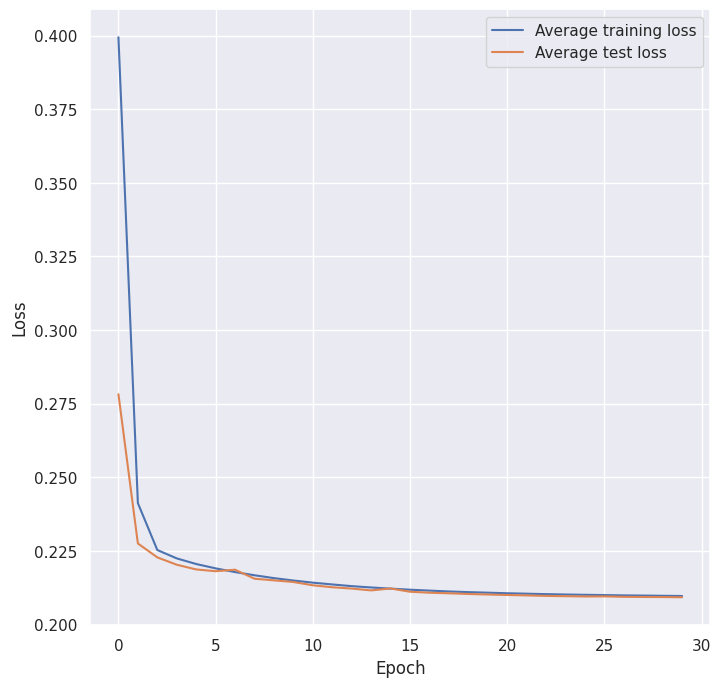

In [59]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

We can now plot the Receiver Operating Characteristic (ROC) curve of the Neural network model to get an evaluation of the performance of this approach. We can also use the BDT data from the paper to print the ROC curve of the BDT approach to get a preliminary comparison between the methods.

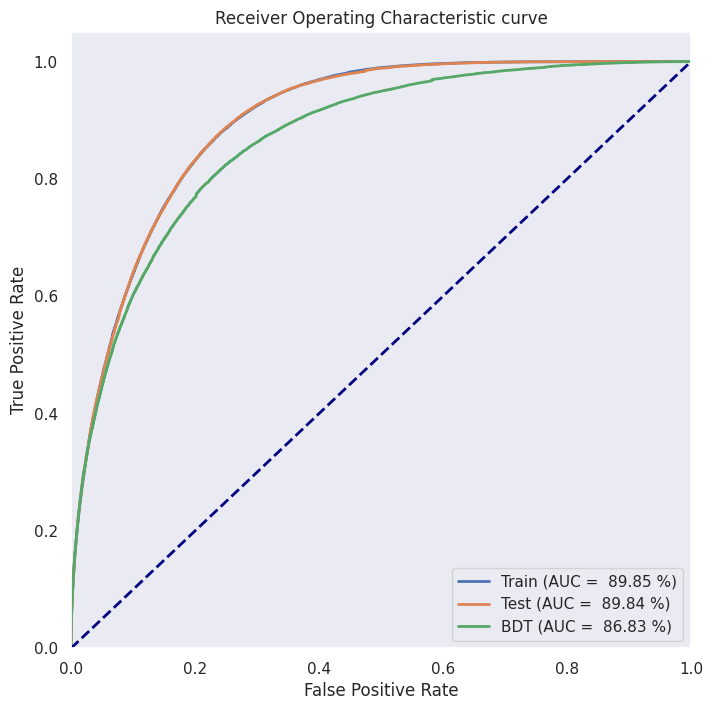

In [60]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, weights, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score, sample_weight=weights)
        plt.plot(
            fpr, tpr,
            linewidth=2,
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

with torch.no_grad():
  NN_train = model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True)
  NN_test = model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True)
plot_rocs([
    (NN_train, y_train, weight_train, "Train"),
    (NN_test, y_test, weight_test, "Test"),
    (BDT_test, y_test, weight_test, "BDT")
])

The results above seem to indicate that the neural network approach can bring some improvement to the BDT approach used in the paper.

A more rigorous evaluation should be performed, where a final selection is decided upon and the expected limits are computed.

### Model Evaluation with pyhf

We will evaluate the model performance with pyhf and compare the BDT approach from the paper with the NN approach used here. We will use some simplifications, such as ignoring all background processes not in the training background sample (we leave it as an exercise to implement the other background samples to any interested individual, the data has been loaded and is available, you just need to apply the trained NN to the required samples). We will also assume an integrated luminsoty of $35.866\,fb^{-1}$ for a more direct comparison to the results from the paper. We also assume that of the 23 signal samples contributing to the $\Delta M$ sample that they all contribute equally, i.e. we average the cross sections across the samples. This is for ease of computation and because we need to choose a single reference cross section for performing the calculations.

In [ ]:
import pyhf
pyhf.set_backend("numpy")
from pyhf.contrib.viz import brazil

luminosity = 35866

#### BDT Approach

In [ ]:
# BDT final selection
sig_yield = weight_test.loc[(BDT_test > 0.47) & (y_test == 1)].sum() * luminosity/(0.33*23)  #Divide by 0.33 to compensate for the splitting factor
bkg_yield = weight_test.loc[(BDT_test > 0.47) & (y_test == 0)].sum() * luminosity/0.33
# cuts (adjust to the signal DM you used):
#  DM10 : 0.31
#  DM20 : 0.39
#  DM30 : 0.47
#  DM40 : 0.48
#  DM50 : 0.45
#  DM60 : 0.50
#  DM70 : 0.46
#  DM80 : 0.44

print(f"Signal yield: {sig_yield}")
print(f"Background yield: {bkg_yield}")


stat_model = pyhf.simplemodels.uncorrelated_background(
    signal=[sig_yield], bkg=[bkg_yield], bkg_uncertainty=[bkg_yield*0.2] # Assume 20% uncertainty on background
)
data = [bkg_yield] + stat_model.config.auxdata

poi_vals = np.linspace(0, 3, 31)
results = [
    pyhf.infer.hypotest(
        test_poi, data, stat_model, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax)
fig.show()

#### NN Approach

For the NN approach, we need to choose a cut value, select the cut value which maximizes FOM

In [ ]:
# Maximize FOM, for now use simple S/sqrt(B)
from math import sqrt
from operator import itemgetter
NN_test = model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True)
cut_vals = np.linspace(-1, 1, 21)
FOM_vals = []
for cut in cut_vals:
  S = weight_test.loc[(NN_test > cut) & (y_test == 1)].sum() * (luminosity/(0.33*23))
  B = weight_test.loc[(NN_test > cut) & (y_test == 0)].sum() * (luminosity/0.33)
  FOM = S/sqrt(B)
  FOM_vals.appen((cut, FOM))

NN_cut = max(FOM_vals, key=itemgetter(1))[0]
NN_cut

In [ ]:
# BDT final selection

sig_yield = weight_test.loc[(NN_test > NN_cut) & (y_test == 1)].sum() * luminosity/(0.33*23)  #Divide by 0.33 to compensate for the splitting factor
bkg_yield = weight_test.loc[(NN_test > NN_cut) & (y_test == 0)].sum() * luminosity/0.33

print(f"Signal yield: {sig_yield}")
print(f"Background yield: {bkg_yield}")

stat_model = pyhf.simplemodels.uncorrelated_background(
    signal=[sig_yield], bkg=[bkg_yield], bkg_uncertainty=[bkg_yield*0.2] # Assume 20% uncertainty on background
)
data = [bkg_yield] + model.config.auxdata

poi_vals = np.linspace(0, 3, 31)
results = [
    pyhf.infer.hypotest(
        test_poi, data, model, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax)
fig.show()

## Train an autoencoder neural network

An autoencoder is a neural network design which is trained to provide the same output as its input. However, the internal layers go through a "bottleneck", forcing the NN to learn an internal representation of the data. As a result, an autoencoder structure is usually thought of as first an encoder, which encodes the data into a simpler representation followed by a decoder which reconstructs the original data from the encoded representation.

![Autoencoder](figs/Autoencoder_structure.png)

(Image: Wikimedia Commons, https://commons.wikimedia.org/wiki/File:Autoencoder_structure.png)

Autoencoders have been used for various purposes, in the context of this exercise we plan to use it as an anomaly detector. The underlying idea of using an autoencoder for anomaly detection is that by training the autoencoder only on background simulated events, when it is presented with signal events, whether of our specific model of interest or any other model, the encoder and decoder portions would not operate correctly for these events, thus the output would not match the input. This would allow to appropriately tag these anomalous events. However, this is an assumed property of an autoencoder and there has been some literature showing cases where this property does not hold true [https://arxiv.org/abs/1810.09136].

We will follow a similar structure to above, for the deep neural network, so not much more explanation will be added.




Prepare the data with only the background processes (not training on signal):

In [14]:
X_train_bck = X_train.loc[y_train == 0]
X_test_bck = X_test.loc[y_test == 0]

Create the data handlers:

In [15]:
class StopAutoencoderDataset(Dataset):
    def __init__(self, X, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pandas.core.frame.DataFrame) else X).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

ae_batch_size=512 # Minibatch learning


ae_train_dataset = StopAutoencoderDataset(X_train_bck, device=device)
ae_test_dataset = StopAutoencoderDataset(X_test_bck, device=device)

ae_train_dataloader = DataLoader(ae_train_dataset, batch_size=ae_batch_size, shuffle=True)
ae_test_dataloader = DataLoader(ae_test_dataset, batch_size=ae_batch_size, shuffle=True)

Create the neural network

In [47]:
class StopAutoEncoder(torch.nn.Module):
    def __init__(self, ninputs, latent_dim=8, device=torch.device("cpu")):
        super().__init__()
        self.device = device

        # Build the encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(ninputs, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, latent_dim)
        )

        # Build the decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, ninputs),
            #torch.nn.Sigmoid() # Can not be use in our case since the input features are scaled with Standard scalar and may have values in nearly any range
            # If using the MinMax scaler, where the input is bounded from 0 to 1, then sigmoid could be considered
            #torch.nn.Tanh() # for inputs bounded between -1 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Inspect the model:

In [48]:
ae_model = StopAutoEncoder(X_train.shape[1], device=device)

print(ae_model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(ae_model, input_size=(ae_batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

StopAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=12, bias=True)
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
StopAutoEncoder                          [512, 12]                 --
├─Sequential: 1-1                        [512, 8]                  --
│    └─Linear: 2-1                       [512, 128]                1,664
│    └─ReLU: 2-2                         [512, 128]                --
│    └─Linear: 2-3                       [512, 64]                 8,256
│    └─ReLU: 2-4                         [512, 64]                 --
│    └─Linear: 2-5                       [512, 36]                 2,340
│    └─ReLU: 2-6                         [512, 36]                 --
│    └─Linear: 2-7                       [512, 18]                 666
│    └─ReLU: 2-8                         [512, 18]                 --
│    └─Linear: 2-9                       [512, 8]                  152
├─Sequential: 1-2                        [512, 12]                 --
│    └─Linear: 2-10                      [512, 18]                 162
│  

In [49]:
#check if the NN can be evaluated some data; note: it has not been trained yet
print (ae_model(torch.tensor(X_train.values[:10],device=device)))

tensor([[-0.0587,  0.0580, -0.0269, -0.0404,  0.0463,  0.1104,  0.0893,  0.0399,
         -0.0645,  0.0345,  0.0487, -0.0203],
        [-0.0589,  0.0583, -0.0270, -0.0403,  0.0461,  0.1104,  0.0894,  0.0397,
         -0.0645,  0.0344,  0.0488, -0.0202],
        [-0.0587,  0.0577, -0.0267, -0.0403,  0.0464,  0.1103,  0.0893,  0.0401,
         -0.0644,  0.0346,  0.0484, -0.0204],
        [-0.0590,  0.0583, -0.0270, -0.0403,  0.0461,  0.1105,  0.0893,  0.0398,
         -0.0645,  0.0345,  0.0488, -0.0202],
        [-0.0586,  0.0576, -0.0267, -0.0403,  0.0465,  0.1104,  0.0893,  0.0402,
         -0.0644,  0.0346,  0.0484, -0.0205],
        [-0.0586,  0.0578, -0.0268, -0.0403,  0.0465,  0.1103,  0.0893,  0.0401,
         -0.0644,  0.0346,  0.0485, -0.0205],
        [-0.0589,  0.0583, -0.0270, -0.0403,  0.0461,  0.1104,  0.0894,  0.0398,
         -0.0645,  0.0345,  0.0489, -0.0202],
        [-0.0589,  0.0580, -0.0268, -0.0404,  0.0462,  0.1104,  0.0893,  0.0399,
         -0.0645,  0.0345,  0.

Define the train loop:

In [50]:
def ae_train_loop(dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    best_loss = np.inf
    for X in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)
        losses.append(loss.detach().cpu())
        if loss < best_loss:
            best_loss = loss.detach().cpu()
            torch.save(model.state_dict(), best_model_path) # Save the full state of the model, to have access to the training history
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses), np.std(losses)

Define the test loop:

In [51]:
def ae_test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred, X).item()
            losses.append(loss)

    return np.mean(losses), np.std(losses)

Define additional parameters:

In [52]:
epochs=40
learningRate = 0.05

# The loss defines the metric deciding how good or bad is the prediction of the network
ae_loss_fn = torch.nn.MSELoss()
# The optimizer decides which path to follow through the gradient of the loss function
ae_optimizer = torch.optim.SGD(ae_model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order for the optimizer to be able to "enter" narrow minima
ae_scheduler = torch.optim.lr_scheduler.ExponentialLR(ae_optimizer, gamma=0.9)

Train the Autoencoder!

In [33]:
train_losses=[]
train_losses_std=[]
test_losses=[]
test_losses_std=[]
best_model_path = "best_stop_ae_model.h5"
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loss, train_loss_std=ae_train_loop(ae_train_dataloader, ae_model, ae_loss_fn, ae_optimizer, ae_scheduler, best_model_path, device)
    test_loss, test_loss_std=ae_test_loop(ae_test_dataloader, ae_model, ae_loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_losses_std.append(train_loss_std)
    test_losses_std.append(test_loss_std)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", ae_scheduler.get_last_lr())
print("Done!")

Epoch 1/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 250.65it/s]


Avg train loss 1.0325507 , Avg test loss 1.0332923210809506 Current learning rate [0.045000000000000005]
Epoch 2/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 298.14it/s]


Avg train loss 0.9180716 , Avg test loss 0.6794534127893846 Current learning rate [0.04050000000000001]
Epoch 3/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 247.82it/s]


Avg train loss 0.62277436 , Avg test loss 0.5445356269433399 Current learning rate [0.03645000000000001]
Epoch 4/30
-------------------------------


100%|██████████| 1221/1221 [00:10<00:00, 121.74it/s]


Avg train loss 0.5057374 , Avg test loss 0.4631807531957056 Current learning rate [0.03280500000000001]
Epoch 5/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 287.56it/s]


Avg train loss 0.43793383 , Avg test loss 0.42167125494630486 Current learning rate [0.02952450000000001]
Epoch 6/30
-------------------------------


100%|██████████| 1221/1221 [00:06<00:00, 191.40it/s]


Avg train loss 0.40026003 , Avg test loss 0.39351984460660416 Current learning rate [0.02657205000000001]
Epoch 7/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 243.73it/s]


Avg train loss 0.35143116 , Avg test loss 0.31376135029527225 Current learning rate [0.02391484500000001]
Epoch 8/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 294.70it/s]


Avg train loss 0.2897536 , Avg test loss 0.2763041746386927 Current learning rate [0.021523360500000012]
Epoch 9/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 217.95it/s]


Avg train loss 0.26688385 , Avg test loss 0.2563224099606983 Current learning rate [0.01937102445000001]
Epoch 10/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 285.73it/s]


Avg train loss 0.2513764 , Avg test loss 0.24624320873220273 Current learning rate [0.01743392200500001]
Epoch 11/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 290.77it/s]


Avg train loss 0.24130082 , Avg test loss 0.24244147624567236 Current learning rate [0.015690529804500006]
Epoch 12/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 214.11it/s]


Avg train loss 0.23049027 , Avg test loss 0.2191292310742254 Current learning rate [0.014121476824050006]
Epoch 13/30
-------------------------------


100%|██████████| 1221/1221 [00:06<00:00, 183.93it/s]


Avg train loss 0.20142008 , Avg test loss 0.18924754820184372 Current learning rate [0.012709329141645007]
Epoch 14/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 278.43it/s]


Avg train loss 0.17936985 , Avg test loss 0.17362744011515774 Current learning rate [0.011438396227480507]
Epoch 15/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 287.49it/s]


Avg train loss 0.17105721 , Avg test loss 0.16863859362479217 Current learning rate [0.010294556604732457]
Epoch 16/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 214.49it/s]


Avg train loss 0.16641876 , Avg test loss 0.16470411926337092 Current learning rate [0.00926510094425921]
Epoch 17/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 299.05it/s]


Avg train loss 0.1631674 , Avg test loss 0.16205163599036934 Current learning rate [0.00833859084983329]
Epoch 18/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 281.61it/s]


Avg train loss 0.16066095 , Avg test loss 0.16007566030986187 Current learning rate [0.007504731764849962]
Epoch 19/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 212.57it/s]


Avg train loss 0.15854302 , Avg test loss 0.1578714357571559 Current learning rate [0.006754258588364966]
Epoch 20/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 281.36it/s]


Avg train loss 0.15682232 , Avg test loss 0.15626504433926355 Current learning rate [0.00607883272952847]
Epoch 21/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 288.76it/s]


Avg train loss 0.15534365 , Avg test loss 0.1549390834816453 Current learning rate [0.005470949456575623]
Epoch 22/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 231.24it/s]


Avg train loss 0.15404457 , Avg test loss 0.15384003544420027 Current learning rate [0.0049238545109180605]
Epoch 23/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 249.87it/s]


Avg train loss 0.15294209 , Avg test loss 0.15289801521490676 Current learning rate [0.004431469059826255]
Epoch 24/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 295.43it/s]


Avg train loss 0.15197234 , Avg test loss 0.1518825648457764 Current learning rate [0.0039883221538436296]
Epoch 25/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 251.39it/s]


Avg train loss 0.15113345 , Avg test loss 0.15106799155107586 Current learning rate [0.003589489938459267]
Epoch 26/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 250.63it/s]


Avg train loss 0.15039256 , Avg test loss 0.1503611144523558 Current learning rate [0.0032305409446133403]
Epoch 27/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 285.55it/s]


Avg train loss 0.14975601 , Avg test loss 0.14983280326478507 Current learning rate [0.0029074868501520064]
Epoch 28/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 285.61it/s]


Avg train loss 0.14919165 , Avg test loss 0.1492172554196343 Current learning rate [0.0026167381651368057]
Epoch 29/30
-------------------------------


100%|██████████| 1221/1221 [00:05<00:00, 210.67it/s]


Avg train loss 0.14869362 , Avg test loss 0.14878987653347236 Current learning rate [0.002355064348623125]
Epoch 30/30
-------------------------------


100%|██████████| 1221/1221 [00:04<00:00, 278.98it/s]

Avg train loss 0.1482555 , Avg test loss 0.14835557597250748 Current learning rate [0.002119557913760813]
Done!


Plot the loss evolution over training

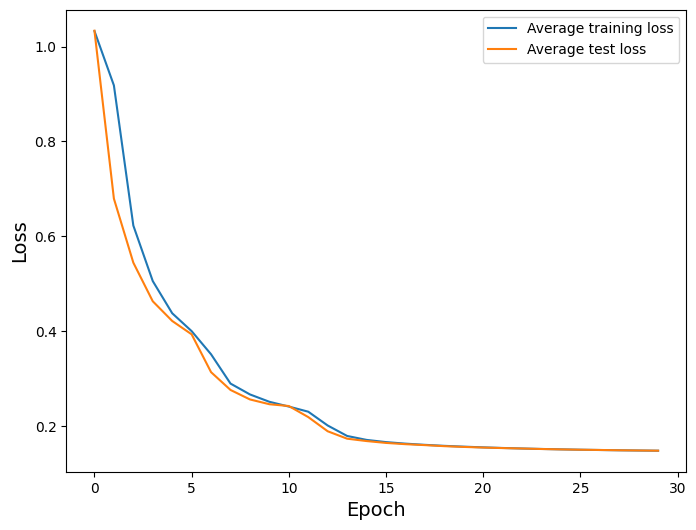

In [34]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

To get the ROC curve, we need to evaluate the autoencoder on a dataset which contains signal events. We also need a way to identify outliers. The loss function we have been using to optimize the neural network provides a convenient and quick way to evaluate how much the output differs from the input, and by using the loss information from the training we are able to define an expected mean and standard deviation for the loss, thus we can now define a criteria to identify outliers and ultimately plot the ROC curve

In [ ]:
with torch.no_grad():
  X_test_tensor = torch.tensor(X_test.to_numpy(),device=ae_model.device)
  prediction = ae_model(X_test_tensor)
  loss = torch.mean((prediction - X_test_tensor)**2, dim=1)
  ae_test = (loss - test_losses[-1])/test_losses_std[-1]


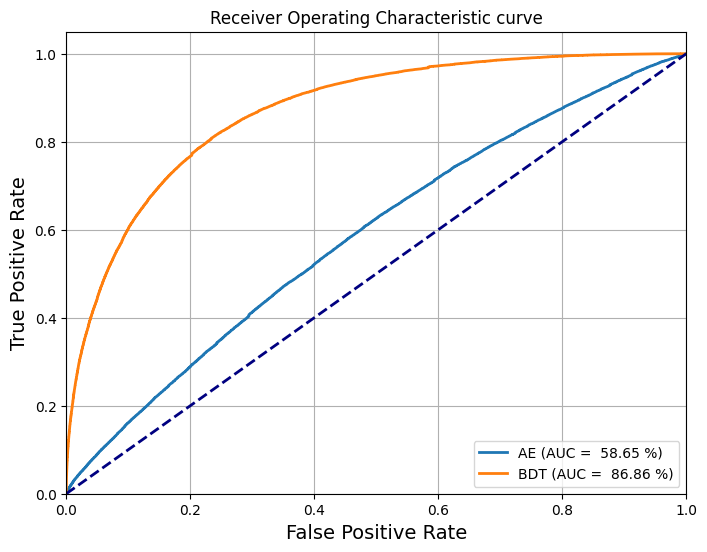

In [ ]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, weights, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score, sample_weight=weights)
        plt.plot(
            fpr, tpr,
            linewidth=2,
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

plot_rocs([
    (ae_test, y_test, weight_test, "AE"),
    (NN_test, y_test, weight_test, "DNN"),
    (BDT_test, y_test, weight_test, "BDT")
])